In [1]:
import mujoco
import cv2
import numpy as np
import yaml
import pickle
import pathlib
import pickle
import mujoco.viewer
from operator import index
import pinocchio as pin
from pinocchio.utils import *
import numpy as np
from mim_robots.robot_loader import load_pinocchio_wrapper, load_mujoco_model, get_robot_list
from numpy.linalg import norm, solve
import time
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from matplotlib import cm, markers
from utils.path_recorder import PathRecorder
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from ipywidgets import widgets, interact

In [2]:
with open('../data.pkl', 'rb') as f:
    data = pickle.load(f)

In [3]:
t = data['time']
X = data['X']
X_dot = data['X_dot']
X_ddot = data['X_ddot']
x0 = data['x0']
goal = data['goal']
num_g = data['num_g']
num_data = data['num_data']
cost_mu = data['cost_mu']
cost_sigma = data['cost_sigma']
cost = data['cost']
num_demo = 5
feature_length = X[0,:,0].shape[0]
bf_number = 50
K = np.diag(np.ones(feature_length))*5
D = 2 * np.sqrt(K)
conv_rate = 0.01
alpha = -np.log(conv_rate)

tau = t[:,-1]
dt = np.gradient(t,axis=-1)
print(X_dot.shape)
print(tau.shape)
print(-alpha/tau)
s = np.exp(np.einsum('i,ij->ij',(-alpha/tau),t))[:,:,None]
s = np.tile(s, (1, 1, bf_number))
s = np.tile(s[0][None, None], (num_demo, 1, 1))
v = np.einsum('i,ijk->ijk',tau,X_dot)
v_dot = np.einsum('i,ijk->ijk',tau,X_ddot)
tau_v_dot = np.einsum('i,ijk->ijk', tau, v_dot)

K_inv = np.linalg.inv(K)
# Dv = np.zeros(shape=(v.shape))
# for i in range(num_demo):
#     Dv[i,:,:] = D@v[i,:,:]

Dv = np.einsum('ij,djf->dif',D,v)
print(D.shape)
print(Dv.shape)
goal = np.tile(goal,(1,X.shape[1],1))
# f_target = tau_v_dot + Dv + K@(X - goal)
print((X-goal).shape)
f_target = tau_v_dot + Dv + np.einsum('ij,djf->dif',K,(X-goal))
print(f_target.shape)

(5, 1000, 2)
(5,)
[-1.51899938 -1.57802875 -1.58780861 -1.83023672 -1.40117981]
(1000, 1000)
(5, 1000, 2)
(5, 1000, 2)
(5, 1000, 2)


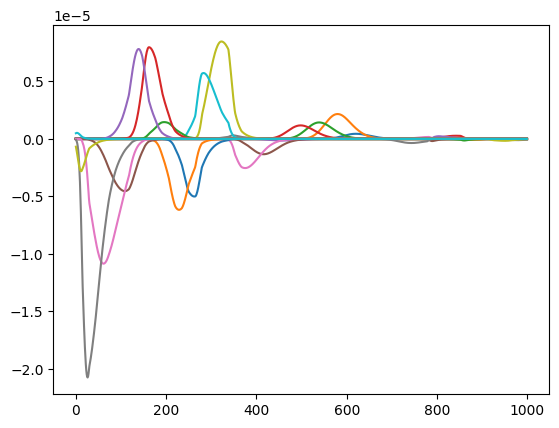

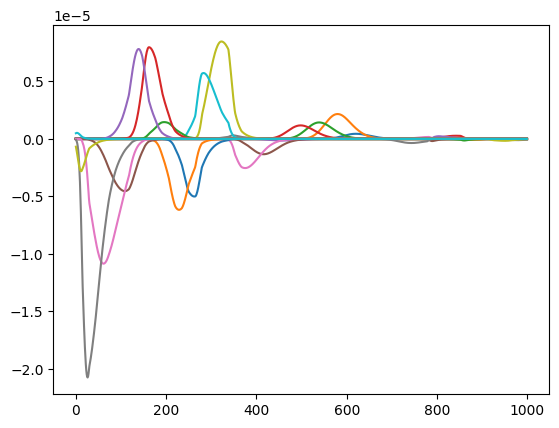

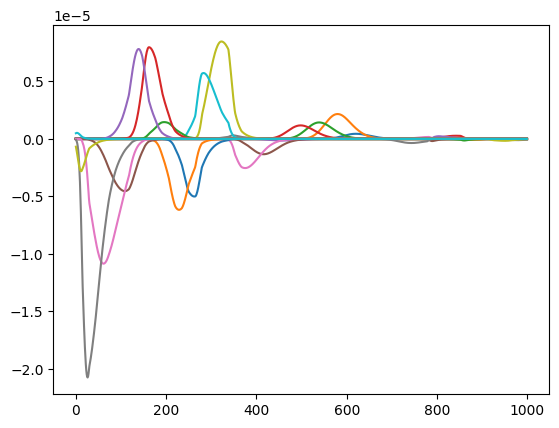

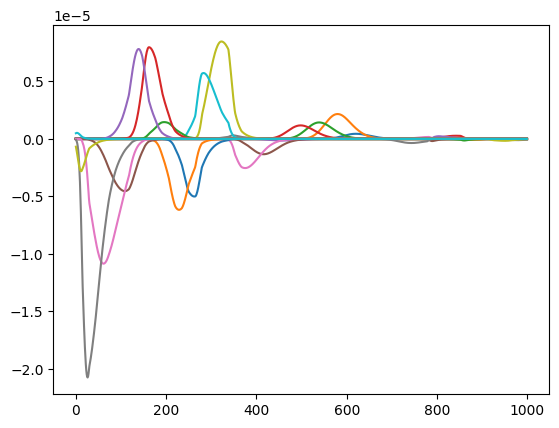

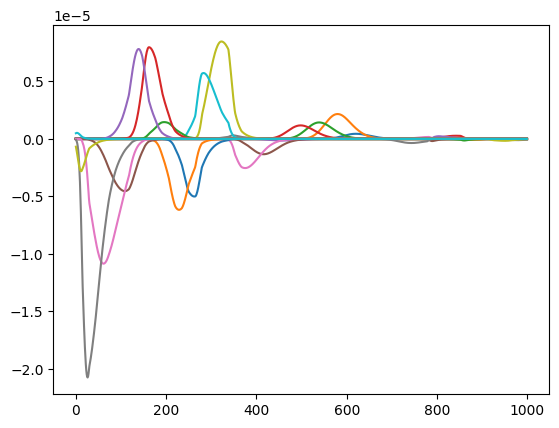

In [278]:
ci= np.logspace(-3, 0, num=bf_number)
h = bf_number / (ci ** 2)
s_tile = np.tile(s[0][None], (num_demo, 1, 1))
ci_tile = np.tile(ci[None,None],(num_demo,feature_length,1))
psi_matrix = np.exp(-h * (s_tile - ci_tile) ** 2)
inv_sum_bfs = 1.0 / np.sum(psi_matrix, axis=-1)
bf_target = np.einsum('dlb,dl->dlb',psi_matrix*s_tile,inv_sum_bfs)

# for i in range(bf_number):
#     plt.plot(bf_target[0,:,i])
# plt.show()
# print(bf_target.shape)
# print(np.concatenate(bf_target,axis=0).shape)

sol = np.linalg.lstsq(
    np.concatenate(f_target,axis=0),
    np.concatenate(bf_target,axis=0),
    rcond=None)

weights = sol[0]

# for i in range(bf_number):
#     plt.plot(psi_matrix[0,:,i])
# plt.show()

w_psi = np.zeros(shape=(psi_matrix.shape))
for i in range(num_demo):
    for j in range(feature_length):
        for k in range(2):
            w_psi[i,j,:] = psi_matrix[i,j,:]*weights[k,:]

# plt.plot(weights[0,:])
# plt.plot(weights[1,:])
# plt.show()

# print(inv_sum_bfs.shape)
for d in range(num_demo):
    for i in range(bf_number):
        plt.plot(w_psi[d,:,i]/inv_sum_bfs[d,:])
    plt.show()


In [2]:
weights.shape

NameError: name 'weights' is not defined

In [343]:
from scipy.stats import multivariate_normal
feature_count = X[0,0,:].shape[0]
R = np.identity(feature_count)*100
u = X_ddot
u.shape


def cost_calculator(X,mu,sigma):
    cost = 0
    for i in range(num_g):
        mvn = multivariate_normal(mu,sigma)
        cost += mvn.pdf(X)
    cost = cost/num_g
    return cost

Q_tau = np.zeros(shape=(num_demo))
for d in range(num_demo):
    q = 0
    q_t = 0
    for i in range(feature_length-1):
        u_t = u[d,i].reshape(-1,1)
        # u_t = u[i,:]
        q_t = cost_calculator(X[d,i],cost_mu[d],cost_sigma[d])
        q += q_t + u_t.T.dot(R).dot(u_t) 
    q_N = cost_calculator(X[d,-1],cost_mu[d],cost_sigma[d])
    Q_tau[d] = q + q_N


/tmp/ipykernel_5965/1860049492.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Q_tau[d] = q + q_N


In [445]:
# eps = np.random.multivariate_normal(np.zeros(shape=(feature_count)),np.identity(feature_count),(num_demo,feature_length,bf_number))
eps = np.random.multivariate_normal(np.zeros(shape=(bf_number)),np.identity(bf_number)/100,(num_demo,feature_length))

g_k = bf_target[0,:,:]
# g_ti_k = np.tile(g_k[:,:,None], (1,1,feature_count))

M_eps = np.zeros(shape=(num_demo, feature_length, bf_number))
g_k = bf_target[d,:,:]
# g_ti_k = np.squeeze(np.tile(g_k[0,:,None], (1,1,feature_count)))
g_ti_k = g_k[0]
R = 1
# R_inv = np.linalg.inv(R)
g_ti_k.shape

for d in range(num_demo):
    g_k = bf_target[d,:,:]
    for i in range(feature_length):
        # g_ti_k = np.squeeze(np.tile(g_k[d,:,None], (1,1,feature_count)))
        g_ti_k = g_k[i].reshape(-1,1)
        # print(g_ti_k.shape)
        
        M_eps[d,i] = ((g_ti_k.dot(g_ti_k.T))/(g_ti_k.T.dot(g_ti_k))).dot(eps[d,i])
print(M_eps.shape)
S = np.zeros(shape=(num_demo,feature_length-1))
S[0,0] = 1
print(S.shape)
for d in range(num_demo):
    print('Computing S for Demonstration Number: ', d+1)
    for i in range(feature_length-1):
        cost_dmp = 0
        q = cost_calculator(X[d,i],cost_mu[d],cost_sigma[d])
        for j in range(i+1,feature_length-1):
            for f in range(feature_count):
                cost_dmp += (weights[f,:].reshape(-1,1).T+M_eps[d,i])@((weights[f,:].reshape(-1,1).T+M_eps[d,i])).T*R
                # print((weights[f,:].reshape(-1,1).T+M_eps[d,i]).T.shape)
        cost_dmp = 0.5*cost_dmp
        S[d,i] = q + cost_dmp
print('Done')



(5, 1000, 50)
(5, 999)
Computing S for Demonstration Number:  1


/tmp/ipykernel_5965/4052366711.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S[d,i] = q + cost_dmp


Computing S for Demonstration Number:  2
Computing S for Demonstration Number:  3
Computing S for Demonstration Number:  4
Computing S for Demonstration Number:  5


In [455]:
P = np.zeros(shape=(num_demo,feature_length)) # P : (num_demo, feature_length)
sum_S = 0
for d in range(num_demo):
    print('Computing P for Demonstration Number: ', d+1)
    sum_S = np.sum(np.exp((-1/alpha)*S[d,:]))
    for i in range(feature_length-1):
        P[d,i] = np.exp((-1/alpha)*S[d,i])
print('Done')

Computing P for Demonstration Number:  1
Computing P for Demonstration Number:  2
Computing P for Demonstration Number:  3
Computing P for Demonstration Number:  4
Computing P for Demonstration Number:  5
Done


In [462]:
d_theta_i = np.zeros(shape=(num_demo, feature_length, bf_number))
for i in range(feature_length):
    for d in range(num_demo):
        d_theta_i[d,i] = P[d,i]*M_eps[d,i,:]

d_theta_i = np.sum(d_theta_i,axis=0) # d_theta_i : (feature_length, bf_number)

(1000, 50)

In [466]:
np.arange(1,10)

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

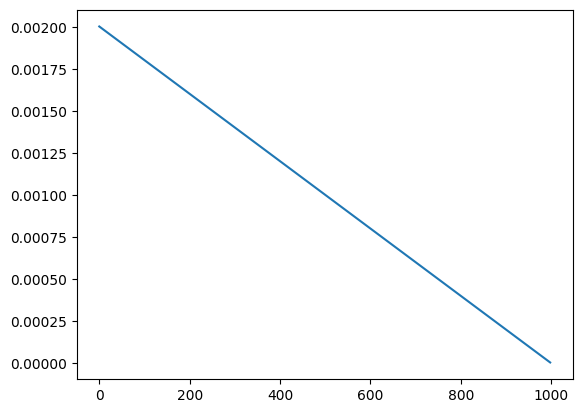

In [470]:
gamma = 0.01
w_i = np.zeros(shape=(feature_length-1,1))
w_sum = np.sum(np.arange(1,feature_length))
for i in range(feature_length-1):
    w_i[i] = (feature_length-i)/w_sum

In [ ]:
def opt_fcn(beta):
    output = 0
    